<center><h1 style="font-size:40px;">Image Classification using CNNs</h1></center>

Welcome to the *fourth* lab for Deep Learning!

In this lab an CNN network to classify RGB images. Image classification refers to classify classes from images. This labs the *dataset* consist of multiple images where each image have a target label for classification.

Good luck!


In [ ]:
import torch
from torch import nn
import os
import imageio
import torchvision
import math
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from collections import OrderedDict

ImportError: attempted relative import with no known parent package

First lets define the ```path``` to the dataset. Make sure you explore the directories of the dataset and get familiar with it!

In [3]:
training_img_dir = "../data/FlyingObjectDataset_10K/training"
validation_img_dir = "../data/FlyingObjectDataset_10K/validation"
testing_img_dir = "../data/FlyingObjectDataset_10K/testing"

We are also going to start using ```tensorboard```:

In [4]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/classification_1') #make sure to adapt this to your needs

Please make sure to read the [doc](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html) to understand how to correctly plot your ```losses``` and ```metrics``` to tensorboard

Ok now that we have the path to the tree different splits, lets start by defining our ```Dataset``` class!
The main two methods we need to define when subclassing ```Dataset``` is ```__getitem__``` and ```__len__```:

In [218]:
from PIL import Image

class FlyingObjects(torch.utils.data.Dataset):
    """Dataset to Flying Object Dataset for the classification task.
       The label information is encoded on the filename, __extract_label will extract the label following the chosen granularity
    
    """
    def __init__(self, root,fine_grained=False,transform=None,augment=False):
        super(FlyingObjects,self).__init__()
        self.root = root
        self.transform = transform
        self.fine_grained = fine_grained

        self.images = [os.path.join(dp,f) for dp, dn, fn in os.walk(os.path.expanduser(self.root+'/image')) for f in fn if f.endswith(".png")]
        self.images.sort()
        if augment:
            self.images = [
                *[(i, 'orig') for i in self.images],
                *[(i, 'fliph') for i in self.images],
                *[(i, 'flipv') for i in self.images],
                *[(i, 'fliphv') for i in self.images]
            ]
        else:
            self.images = [(i, 'orig') for i in self.images]
        
        self.classes = [
            'square_red',
            'square_green',
            'square_blue',
            'square_yellow',
            'triangle_red',
            'triangle_green',
            'triangle_blue',
            'triangle_yellow',
            'circular_red',
            'circular_green',
            'circular_blue',
            'circular_yellow',
            'background'
        ] if self.fine_grained else [
            'square',
            'triangle',
            'circular',
            'background']
        self.labels = [self.__extract_label(f[0]) for f in self.images]
    

    def get_classes(self):
        return self.classes
    
    
    def __extract_label(self, image_file):
        """Extract label from image_file name"""
        path, img_name = os.path.split(image_file)
        names = img_name.split(".")[0].split("_")

        currLabel = names[1] + "_" + names[2] if self.fine_grained else names[1]

        if currLabel in self.classes:
            label = self.classes.index(currLabel)
        else:
            raise ValueError("ERROR: Label " + str(currLabel) + " is not defined!")
        return label
    
    def __getitem__(self, index):
        # get data
        #x = imageio.v2.imread(self.images[index])
        x = Image.open(self.images[index][0])
        if self.images[index][1] == "fliph":
            x = x.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        elif self.images[index][1] == "flipv":
            x = x.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
        elif self.images[index][1] == "fliphv":
            x = x.transpose(Image.Transpose.FLIP_LEFT_RIGHT).transpose(Image.Transpose.FLIP_TOP_BOTTOM)
        
        if self.transform:
            x = self.transform(x)
        else:
            x = torch.from_numpy(x)
        x = x.float()
   
        # get label
        y = self.labels[index]
        #y = np.eye(len(self.get_classes()))[y]
        #y = torch.tensor(y)
        return x, y

    def __len__(self):
        return len(self.images)

We can define our transformations. Note that not all transformations are considered ```Data Augmentation```.
The following transformations are used to convert our data to ```Tensor``` and resize our images to the desired size!

In [219]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
#    torchvision.transforms.Resize((64, 64)),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
#    torchvision.transforms.Resize((64, 64))
])

# Question 1

Define the three dataloaders for the three splits: ```train```, ```validation``` and ```test```

Do not forget to visualize the data!

In [220]:
def image_with_labels(data, labels, title:str=None, nimages:int=10, nrows:int=2, fig_dimension=1,title_size=10, label_prefix="Label: "):
    """Creates a grid of images with/without labels.

    :param data: tensor": B,W,H,C
    :param labels: tensor":  (Default value = None)
    :param title: str:  (Default value = None)
    :param nimages: int:  (Default value = 10)
    :param nrows: int:  (Default value = 2)
    :param fig_dimension: Default value = 1)
    :param data:"tensor": 
    :param labels:"tensor":  (Default value = None)
    :param title:str:  (Default value = None)
    :param nimages:int:  (Default value = 10)
    :param nrows:int:  (Default value = 2)

    """
    image_ratio = data[0].shape[0] /data[0].shape[1]
    if len(data)< nimages:
        nimages = len(data)
 
    columns = math.ceil(nimages/nrows)
    
    if nrows*columns > nimages:
        nrows = math.ceil(nimages/columns)
    
    fig = plt.figure(figsize=(fig_dimension*columns,1.4*fig_dimension*nrows*image_ratio))
    for i in range(0, nimages):
        ax = fig.add_subplot(nrows, columns, i+1)
        ax.imshow(data[i])
        ax.set_xlabel(f"{label_prefix}{labels[i]}") if labels is not None else None
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)

    if labels is None:
        fig.suptitle(title,x=0.5, y=.95, size=title_size) 
        
        fig.subplots_adjust(
            left=0,
            right=0.9,
            top=0.9,
            bottom=0,
            wspace=0.1,
            hspace=-0.45
        )
    else:
        fig.suptitle(title) #,x=0.45, y=.95
        
        fig.subplots_adjust(
            #left=0,
            #right=1,
            top=0.9,#+((nrows-1)*0.045),
            #bottom=0,
            wspace=0,
            #hspace=0
        )
        
    #plt.tight_layout(h_pad=0,w_pad=0)
    fig.tight_layout(pad=0, h_pad=0,w_pad=0)
    plt.show()

In [221]:
train_dataset = FlyingObjects(training_img_dir, transform=train_transform, augment=True, fine_grained=True)
valid_dataset = FlyingObjects(validation_img_dir, transform=test_transform, fine_grained=True)
test_dataset = FlyingObjects(testing_img_dir, transform=test_transform, fine_grained=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

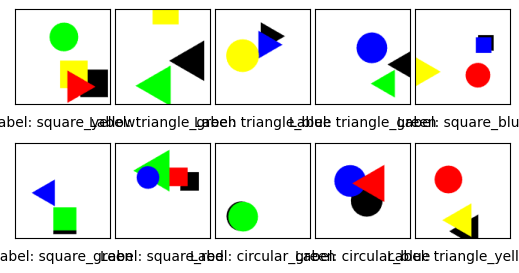

In [223]:
features, labels = next(iter(train_loader))
image_with_labels(np.transpose(features[:10], (0, 2, 3, 1)), [train_dataset.classes[l] for l in labels[:10]])

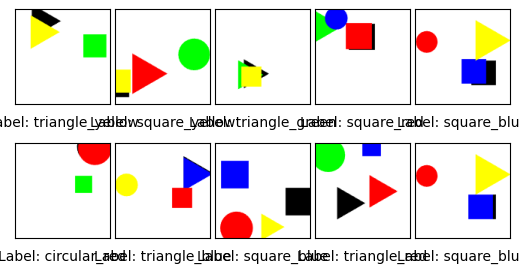

In [222]:
features, labels = next(iter(valid_loader))
image_with_labels(np.transpose(features[:10], (0, 2, 3, 1)), [train_dataset.classes[l] for l in labels[:10]])

Let's start with a very simple network

In [197]:
class SimpleModel(torch.nn.Module):
    def __init__(self,num_channels, num_classes, input_shape=(128,128)):
        super(SimpleModel,self).__init__()
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(64*input_shape[1]//4*input_shape[1]//4, 64) # Calculated with the size. why //4
        self.fc2 = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.5)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('leakyrelu',nn.LeakyReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
       
        out = out.view(out.size(0), -1)

        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out

# Question 2

Get inspired on the code you did on the previous lab and create your ```train function```. It might be useful to think about having a ```predict``` function too. Check the code of the previous lab if you need ideas!

Do not forget, to train you need an ```optimizer```, ```loss function``` and an instance of your ```model```! If you need more inspiration check [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)!

In [184]:
# from https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-with-tensorboard-and-pytorch-3344ad5e7209
def createConfusionMatrix(net, loader):
    y_pred = [] # save predction
    y_true = [] # save ground truth

    # iterate over data
    for inputs, labels in loader:
        output = net(inputs)  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth

    # constant for classes
    classes = train_dataset.classes[:-1]

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index=[i for i in classes],
                         columns=[i for i in classes])
    plt.figure(figsize=(12, 7))    
    return sn.heatmap(df_cm, annot=True).get_figure()

def train(epoch_number, optimizer, loss, model, train_loader, valid_loader=None, lr=0.001):
    writer = SummaryWriter()
    
    opt = optimizer(model.parameters(), lr=lr, weight_decay=1e-5)
    for epoch in range(epoch_number):
        step = (epoch + 1) * len(train_loader) - 1
        
        model.train()
        train_loss = 0
        train_correct = 0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            opt.zero_grad()
            outputs = model(inputs)
            l = loss(outputs, labels)
            l.backward()
            opt.step()
            writer.add_scalar("Loss/batch", l, epoch*len(train_loader) + batch_idx)
            train_loss += l.item()
            train_correct += torch.sum(torch.max(outputs, 1).indices == labels).item()
            if (batch_idx % 10) == 0:
                print("\r[Batch {} of Epoch {}]\t Loss:{}".format(batch_idx, epoch, l), end="")
        train_loss /= len(train_loader)
        train_correct /= len(train_loader)
        writer.add_scalar("Loss/train", train_loss, step)
        writer.add_scalar("Accuracy/train", train_correct, step)
        writer.add_figure("CF/train", createConfusionMatrix(model, train_loader), step)
                
        if valid_loader:
            valid_loss = 0
            valid_correct = 0
            predictions = []
            truth = []
            model.eval()
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                predictions.extend((torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy())
                truth.extend(labels.data.cpu().numpy())
                l = loss(outputs, labels)
                valid_loss += l.item()
                valid_correct += torch.sum(torch.max(outputs, 1).indices == labels).item()
            valid_loss /= len(valid_loader)
            valid_correct /= len(valid_loader)
            writer.add_scalar("Loss/valid", valid_loss, step)
            writer.add_scalar("Accuracy/valid", valid_correct, step)
            writer.add_figure("CF/valid", createConfusionMatrix(model, valid_loader), step)
    writer.add_graph(model, next(iter(train_loader))[0])

def predict(model, loader):
    model.eval()
    predicted, truth = [], []
    for inputs, labels in loader:
        outputs = model(inputs)
        predicted.extend(outputs.numpy())
        truth.extend(outputs.numpy())
    return predicted, truth

# Question 3

Now that you have your train function. Train the network until it overfits. Which ```hyperparameters``` allowed you to overfit?

In [224]:
model = SimpleModel(3, len(train_dataset.classes)-1)

train(5, torch.optim.Adam, torch.nn.CrossEntropyLoss(), model, train_loader, valid_loader, lr=0.0005)

[Batch 670 of Epoch 4]	 Loss:0.0023046585265547037

To help you visualize the results we provide a ```confusion matrix function```. 

In [67]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import numpy as np

In [110]:
def matrix(loader,net,classes):
    y_pred = []
    y_true = []
    for inputs, labels in loader:
            output = net(inputs)
            y_pred.extend(torch.max(torch.exp(output), 1).indices.numpy())
            y_true.extend(labels.data.cpu().numpy())
            break

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,display_labels=classes)
    disp.plot()

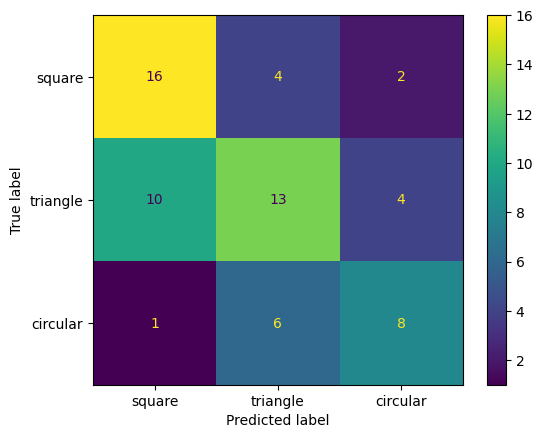

In [213]:
matrix(valid_loader, model, train_dataset.classes[:-1])

# Question 4
Go through the [doc](https://pytorch.org/vision/stable/transforms.html) about data augmentation transformations and use some in your pipeline. Did the ones you try improve your model? Why?

# Question 5

Redo the previous questions with an image size of ```128x128```. Make sure to note what changed and why. Compare both versions on ```Tensorboard``` plots.

# Question 6

Once you have a good model for ```128x128``` without ```fine grain``` redo the experiments with ```fine grain```. How did the performance change? And why?

In [ ]:
# 64, no augment - Nov03_20-06-57_CND0485WX8
# 64, augment - Nov03_20-48-03_CND0485WX8
# 128, no augment - Nov03_21-37-41_CND0485WX8
# 128, augment - Nov03_22-11-30_CND0485WX8
# 128, real augment - Nov04_07-34-12_CND0485WX8
# 128, real augment, fine - Nov04_16-48-15_CND0485WX8